In [1]:
import geopandas as gpd # Geospatial data operations
import rasterio as rio # Geospatial imagery manipulation
import rasterio.plot
import pandas as pd # Tabular data
import os
import re
import rapidfuzz # Fuzzy string matching
from tqdm.auto import tqdm # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map # Parallel operations
import matplotlib # Plots
import matplotlib.pyplot as plt
import shapely # Polygon operations
import solaris.tile as tile # Tile splitting
import solaris.data.coco as coco
import contextlib
import io
import rasterio # Raster imagery operations
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.merge import merge # Merging tiles into mosaics
from glob import glob # Finding files
from shapely.geometry import box # Bounding box operations
matplotlib.rcParams['figure.figsize'] = (20, 10)
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Match shapefiles to images

In [2]:
# A complete filelist of the MaxarImagery & Retrolens folders, generated with the unix command:
# find MaxarImagery/ Retrolens/ > ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt
filelist = pd.read_csv("ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt", header=None).iloc[:,0]
filelist

0                                                                         MaxarImagery/
1                                                              MaxarImagery/._.DS_Store
2                                                                 MaxarImagery/HighFreq
3                                                       MaxarImagery/HighFreq/HawkesBay
4                                           MaxarImagery/HighFreq/HawkesBay/._.DS_Store
                                              ...                                      
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
141474    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2.aux.xml
141475    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif.aux.xml
141476    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_20SEP1980_mosaic.jp2.aux.xml
141477        Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2.ovr
Name: 0, Length: 141478, dtype: 

In [3]:
def check_filename(filename):
    if "Taranaki" in filename or "Canterbury" in filename or "Oamaru" in filename:
        return False
    else:
        # This regex only matches shapefiles that contain something date-like in their names
        match = re.search(r'/Shorelines/\w+\d\w+\d{4}\w*.shp$', filename)
        return bool(match)

df = filelist[filelist.apply(check_filename)].to_frame(name="filename")
df

,filename
1344,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp
1368,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp
1371,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp
1375,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp
1385,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp
...,...
140219,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp
140221,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp
140224,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp
140278,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp


In [4]:
images = filelist[filelist.str.contains("/Stack/", case=False) & filelist.str.endswith((".jpg", ".jp2", ".tif"))]
images

236       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_2.tif
237       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_1.tif
239         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_12MAR2018.tif
242         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif
254         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_25DEC2015.tif
                                              ...                                      
141460            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_19NOV1972_mosaic.jp2
141466            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2
141469            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_10NOV1977_mosaic.tif
141470            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
Name: 0, Length: 1904, dtype: ob

In [5]:
# When fuzzy matching, ignore these strings
# _0 will ignore leading zeros in dates
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", ".mosaic", "_cliff", "_beach", "_beachcliffsegment", "_MF.shp", "_MT.shp", "_0", "_1.tif", "_2.tif", "_3.tif", "_LDS", "_"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    # Basename only
    filename = os.path.basename(filename)
    return filename

def get_matching_image(filename):
    dirname = os.path.dirname(filename)
    RL_dirname = dirname.replace("Stack/", "").replace("Shorelines", "Stack").replace("MaxarImagery/HighFreq", "Retrolens")
    Maxar_dirname = dirname.replace("Imagery/Shorelines", "Imagery/Stack").replace("Shorelines", "Imagery/Stack").replace("Retrolens", "MaxarImagery/HighFreq")
    Maxar_dirname_uppercase = Maxar_dirname.replace("Stack", "STACK")
    Maxar_dirname_outside_Imagery = Maxar_dirname.replace("Imagery/Stack", "Stack")
    all_files_in_folder = images[images.str.startswith((RL_dirname, Maxar_dirname, Maxar_dirname_uppercase, Maxar_dirname_outside_Imagery))]
    if len(all_files_in_folder) == 0:
        return "", 0
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    return match, score

df["matched_image"], df["match_score"] = zip(*df.filename.apply(get_matching_image))
print("Perfect matches:", sum(df.match_score == 100))
print("Imperfect matches:", sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

Perfect matches: 741
Imperfect matches: 115


## Investigate metadata about the matched images

In [6]:
def get_meta(row):
    image = rio.open(row.matched_image)
    gdf = gpd.read_file(row.filename)
    row = row.to_dict()
    row["n_lines"] = len(gdf.explode(index_parts=False))
    row.update(image.profile)
    row["GCPs"] = len(image.gcps[0])
    return row

metafile = "meta.csv"
if os.path.isfile(metafile):
    meta = pd.read_csv(metafile)
else:
    meta = pd.DataFrame(df.progress_apply(get_meta, axis=1).tolist())
    meta.to_csv("meta.csv", index=False)
meta

,filename,matched_image,match_score,n_lines,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,photometric
0,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_13DEC2013.tif,100.0,4,GTiff,uint8,NaN,8244,5340,3,NaN,"| 0.50, 0.00, 1617063.23|\n| 0.00,-0.50, 5430387.79|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,4,NaN
1,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_22NOV2017.tif,100.0,8,GTiff,uint8,NaN,8244,5340,3,NaN,"| 0.50, 0.00, 1617063.23|\n| 0.00,-0.50, 5430387.79|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,6,NaN
2,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_14DEC2006.tif,100.0,4,GTiff,uint8,NaN,6870,4450,3,NaN,"| 0.60, 0.00, 1617063.43|\n| 0.00,-0.60, 5430387.80|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,3,NaN
3,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_18MAR2021.tif,100.0,4,GTiff,uint8,NaN,8244,5355,3,NaN,"| 0.50, 0.00, 1617063.06|\n| 0.00,-0.50, 5430395.29|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,6,NaN
4,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_08FEB2016.tif,100.0,9,GTiff,uint8,NaN,12082,7827,3,NaN,"| 0.34, 0.00, 1617063.16|\n| 0.00,-0.34, 5430388.04|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_29OCT1973_mosaic.tif,100.0,6,GTiff,int32,2.147484e+09,8756,25098,1,NaN,"| 0.33, 0.00, 1764342.31|\n| 0.00,-0.33, 5469726.56|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,band,5,NaN
852,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_15APR1966_mosaic.tif,100.0,5,GTiff,int32,2.147484e+09,13171,34650,1,"PROJCS[""NZGD_2000_Transverse_Mercator"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""GRS 1980"",6378137,2...","| 0.23, 0.00, 1764459.39|\n| 0.00,-0.23, 5469625.71|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,band,0,NaN
853,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_17APR1952_mosaic.tif,100.0,4,GTiff,int32,2.147484e+09,14167,31280,1,NaN,"| 0.27, 0.00, 1763537.25|\n| 0.00,-0.27, 5469157.98|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,band,7,NaN
854,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_02JAN1988_mosaic.jp2,100.0,9,JP2OpenJPEG,uint16,2.560000e+02,10654,18819,1,NaN,"| 0.39, 0.00, 1762602.58|\n| 0.00,-0.39, 5466346.26|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,NaN,4,NaN


In [7]:
meta.crs.value_counts(dropna=False)

PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2193"]]                          581
NaN                                                                                                                                                                                                                                                                                                                                           

In [8]:
meta.GCPs.value_counts()

0     669
4      40
3      31
5      30
7      27
6      24
8      12
9       5
11      4
21      3
28      2
14      2
10      2
12      2
16      1
23      1
13      1
Name: GCPs, dtype: int64

In [9]:
meta.columns

Index(['filename', 'matched_image', 'match_score', 'n_lines', 'driver',
       'dtype', 'nodata', 'width', 'height', 'count', 'crs', 'transform',
       'blockxsize', 'blockysize', 'tiled', 'compress', 'interleave', 'GCPs',
       'photometric'],
      dtype='object')

In [10]:
meta.driver.value_counts()

JP2OpenJPEG    567
GTiff          288
JPEG             1
Name: driver, dtype: int64

In [11]:
meta["count"].value_counts()

3    796
1     59
4      1
Name: count, dtype: int64

In [12]:
meta.dtype.value_counts()

uint16    555
uint8     287
int32      14
Name: dtype, dtype: int64

In [13]:
meta.nodata.value_counts()

2.560000e+02    555
2.147484e+09     14
2.550000e+02      2
Name: nodata, dtype: int64

## Make mosaics for LINZ images

In [71]:
maybe_LDS = df[(df.match_score < 100) & df.filename.str.startswith("Retrolens")].copy()
maybe_LDS

,filename,matched_image,match_score
46010,Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_16JAN2019_NEL18R.shp,Retrolens/Nelson/BoulderBank/Stack/BoulderBank_13JAN2000_mosaic.jp2,73.913043
46231,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_18NOV2005.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_17JAN1957_mosaic.jp2,72.727273
46232,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_27SEP2017.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_22SEP1969_mosaic.jp2,81.818182
46294,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_31JAN2021.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_17JAN1957_mosaic.jp2,81.818182
46300,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_30DEC2015.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_20NOV1983_mosaic.jp2,72.727273
...,...,...,...
138939,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_27APR2020.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_17APR1952_mosaic.tif,80.000000
138969,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_15MAR2017.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_15APR1966_mosaic.tif,80.000000
139007,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_04APR2014.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_28APR1948_mosaic.tif,82.051282
139012,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_04MAR2010.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_24MAR1970_mosaic.tif,87.179487


In [146]:
maybe_LDS.filename.to_csv("maybe_LDS.csv", index=False)

## Match shapefiles with the corresponding index tiles shapefile
- First get the bounds of every tile
- Tiles that spatially match the bounds of a drawn EOV shapefile will be used to create the corresponding mosaic

In [135]:
tilelist = pd.DataFrame({"filename": glob("DigitalJPGs/**/*.jpg", recursive=True)})
tilelist["region"] = tilelist.filename.str.split("/").str[1]
tilelist["tilename"] = tilelist.filename.str.split("/").str[-1].str.replace(".jpg", "")
def get_bounds(f):
    return rio.open(f).bounds
tilelist["bounds"] = thread_map(get_bounds, tilelist.filename)
tilelist

/tmp/ipykernel_1404694/3319933937.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tilelist["tilename"] = tilelist.filename.str.split("/").str[-1].str.replace(".jpg", "")
100%|██████████| 54692/54692 [05:39<00:00, 161.16it/s]   


,filename,region,tilename,bounds
0,DigitalJPGs/Southland/southland-central-otago-04m-rural-aerial-photos-2015-2017/CD13_5K_1009.jpg,Southland,CD13_5K_1009,"(1319200.0, 4938000.0, 1321600.0, 4941600.0)"
1,DigitalJPGs/Southland/southland-central-otago-04m-rural-aerial-photos-2015-2017/CD11_5K_0910.jpg,Southland,CD11_5K_0910,"(1273600.0, 4941600.0, 1276000.0, 4945200.0)"
2,DigitalJPGs/Southland/southland-central-otago-04m-rural-aerial-photos-2015-2017/CE14_5K_0201.jpg,Southland,CE14_5K_0201,"(1324000.0, 4930800.0, 1326400.0, 4934400.0)"
3,DigitalJPGs/Southland/southland-central-otago-04m-rural-aerial-photos-2015-2017/CF08_5K_0301.jpg,Southland,CF08_5K_0301,"(1180000.0, 4891200.0, 1182400.0, 4894800.0)"
4,DigitalJPGs/Southland/southland-central-otago-04m-rural-aerial-photos-2015-2017/CC16_5K_0606.jpg,Southland,CC16_5K_0606,"(1384000.0, 4988400.0, 1386400.0, 4992000.0)"
...,...,...,...,...
54687,DigitalJPGs/WestCoast/WST16R/by/2017_BY12_5000_0210.jpg,WestCoast,2017_BY12_5000_0210,"(1297600.0, 5146800.0, 1300000.0, 5150400.0)"
54688,DigitalJPGs/WestCoast/WST16R/by/2017_BY10_5000_1010.jpg,WestCoast,2017_BY10_5000_1010,"(1249600.0, 5118000.0, 1252000.0, 5121600.0)"
54689,DigitalJPGs/WestCoast/WST16R/by/2017_BY12_5000_1006.jpg,WestCoast,2017_BY12_5000_1006,"(1288000.0, 5118000.0, 1290400.0, 5121600.0)"
54690,DigitalJPGs/WestCoast/WST16R/by/2017_BY12_5000_0106.jpg,WestCoast,2017_BY12_5000_0106,"(1288000.0, 5150400.0, 1290400.0, 5154000.0)"


In [140]:
tilelist.bounds = tilelist.bounds.progress_apply(lambda b: box(*b))

100%|██████████| 54692/54692 [00:01<00:00, 46280.39it/s]


In [143]:
tilelist = gpd.GeoDataFrame(tilelist, geometry="bounds")
tilelist.to_parquet("tilelist.parquet")

In [152]:
# This cell might useful for finding matches, based on geospatial correlation
for filename in tqdm(maybe_LDS.filename):
    break
    df = gpd.read_file(filename)
    if len(df) == 0:
        continue
    bounds = df.total_bounds
    intersecting_tiles = tilelist[tilelist.intersects(box(*bounds))]
    print(f"{filename} matches:\n\t{len(intersecting_tiles)} tiles from:\n\t\t{intersecting_tiles.filename}")

  0%|          | 0/108 [00:00<?, ?it/s]


In [162]:
LDS = pd.read_csv("maybe_LDS.csv").dropna()
LDS

,filename,matched_tile_root
0,Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_16JAN2019_NEL18R.shp,DigitalJPGs/Nelson/NEL18R
18,Retrolens/Auckland/Whatipu/Shorelines/Whatipu_07APR2010.shp,DigitalJPGs/Auckland/Auckland 2010R
22,Retrolens/Auckland/Omaha/Shorelines/Omaha_04DEC2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012
23,Retrolens/Auckland/PakiriBeach_North/Shorelines/PakiriBeach_North_06NOV2015.shp,DigitalJPGs/Northland/Northland 0.40m Rural Aerial Photos 2014-16
24,Retrolens/Auckland/TeArai/Shorelines/TeArai_06NOV2015.shp,DigitalJPGs/Northland/Northland 0.40m Rural Aerial Photos 2014-16
25,Retrolens/Auckland/Orewa/Shorelines/Orewa_08MAR2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011
26,Retrolens/Auckland/PakiriBeach/Shorelines/PakiriBeach_04MAR2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012
27,Retrolens/Auckland/KawakawaBay/Shorelines/KawakawaBay_03JAN2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011
31,Retrolens/Otago/Ryans_Pipikaretu_Penguin_TeRauoneBeach/Stack/Shorelines/Ryans_Pipikaretu_Penguin_TeRauoneBeach_29JAN2019.shp,DigitalJPGs/Otago/otago-03m-rural-aerial-photos-2017-2019
36,Retrolens/Otago/Tautuku_Beach/Shorelines/Tautuku_02May2013.shp,DigitalJPGs/Southland/STH13R


For each file, create a mosaic from the corresponding tiles

In [163]:
done = LDS.filename.apply(lambda f: os.path.isfile(f.replace(".shp", ".tif")))
display(done.value_counts(dropna=False))
LDS = LDS[~done]
LDS

False    31
True     25
Name: filename, dtype: int64

,filename,matched_tile_root
0,Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_16JAN2019_NEL18R.shp,DigitalJPGs/Nelson/NEL18R
18,Retrolens/Auckland/Whatipu/Shorelines/Whatipu_07APR2010.shp,DigitalJPGs/Auckland/Auckland 2010R
22,Retrolens/Auckland/Omaha/Shorelines/Omaha_04DEC2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012
23,Retrolens/Auckland/PakiriBeach_North/Shorelines/PakiriBeach_North_06NOV2015.shp,DigitalJPGs/Northland/Northland 0.40m Rural Aerial Photos 2014-16
24,Retrolens/Auckland/TeArai/Shorelines/TeArai_06NOV2015.shp,DigitalJPGs/Northland/Northland 0.40m Rural Aerial Photos 2014-16
25,Retrolens/Auckland/Orewa/Shorelines/Orewa_08MAR2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011
26,Retrolens/Auckland/PakiriBeach/Shorelines/PakiriBeach_04MAR2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012
27,Retrolens/Auckland/KawakawaBay/Shorelines/KawakawaBay_03JAN2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011
31,Retrolens/Otago/Ryans_Pipikaretu_Penguin_TeRauoneBeach/Stack/Shorelines/Ryans_Pipikaretu_Penguin_TeRauoneBeach_29JAN2019.shp,DigitalJPGs/Otago/otago-03m-rural-aerial-photos-2017-2019
36,Retrolens/Otago/Tautuku_Beach/Shorelines/Tautuku_02May2013.shp,DigitalJPGs/Southland/STH13R


In [166]:
for i, row in tqdm(LDS.iterrows(), total=len(LDS)):
    filename = row.filename
    mosaic_filename = filename.replace(".shp", ".tif")
    bounds = gpd.read_file(filename).total_bounds
    intersecting_tiles = tilelist[tilelist.intersects(box(*bounds)) & tilelist.filename.str.startswith(row.matched_tile_root)]
    tiles = list(intersecting_tiles.filename)
    Z, transform = merge(tiles)
    with rasterio.open(
        mosaic_filename,
        'w',
        driver='GTiff',
        height=Z.shape[1],
        width=Z.shape[2],
        count=Z.shape[0],
        dtype=Z.dtype,
        crs=rio.open(tiles[0]).crs,
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(Z)

 61%|██████▏   | 19/31 [11:34<10:32, 52.69s/it]

In [18]:
LDS.matched_image = LDS.filename.str.replace(".shp", ".tif")
LDS.to_csv("LDS_matches.csv", index=False)

/tmp/ipykernel_1404694/1669793611.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  WST16R.matched_image = WST16R.filename.str.replace(".shp", ".tif")


### Algorithm for converting polyline shapefile to polygon annotations, labelled as sea or land

In [22]:
coastline = gpd.read_file("lds-nz-coastlines-and-islands-polygons-topo-150k-FGDB.zip!nz-coastlines-and-islands-polygons-topo-150k.gdb")

In [27]:
# Get a random (known-good) annotation
sample = df[df.match_score == 100].sample(1)
display(sample)
image_filename = sample.matched_image.iloc[0]
image = rio.open(image_filename)
sample_gdf = gpd.read_file(sample.filename.iloc[0])
sample_gdf

,filename,matched_image,match_score
78639,Retrolens/Southland/ColacBay/Shorelines/ColacBay_03MAR1967.shp,Retrolens/Southland/ColacBay/Stack/ColacBay_03MAR1967_mosaic.jp2,100.0


,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,geometry
0,0,Southland,ColacBay,1967-03-03,03/03/1967,MF,1500,NaN,RL,"LINESTRING (1206213.131 4852315.920, 1206215.512 4852319.889, 1206218.687 4852325.445, 1206223.714 4852333.118, 1206226.625 48..."


In [28]:
def line_to_split_bbox(geo):
    bounding_box = geo.envelope
    split_bbox = shapely.ops.split(bounding_box, geo)
    return split_bbox

split_bboxes = sample_gdf.geometry.apply(line_to_split_bbox).explode(index_parts=True).reset_index()
#split_bboxes.geometry = split_bboxes.geometry.buffer(0)
split_bboxes["area"] = split_bboxes.area
split_bboxes = split_bboxes[split_bboxes.area > 1e5]
split_bboxes

,level_0,level_1,geometry,area
0,0,0,"POLYGON ((1210112.303 4853689.640, 1210112.303 4852315.920, 1206213.131 4852315.920, 1206215.512 4852319.889, 1206218.687 4852...",4.319792e+06
2,0,2,"POLYGON ((1206213.131 4852315.920, 1206213.131 4853725.094, 1209670.713 4853725.094, 1209659.865 4853724.565, 1209653.912 4853...",1.167917e+06


In [29]:
relevant_coastline = coastline.clip(split_bboxes.total_bounds)
split_bboxes["area_inland"] = split_bboxes.clip(relevant_coastline).area
split_bboxes["fraction_inland"] = split_bboxes.area_inland / split_bboxes.area
split_bboxes["class"] = split_bboxes.fraction_inland.apply(lambda f: "land" if f > .5 else "sea")
split_bboxes

,level_0,level_1,geometry,area,area_inland,fraction_inland,class
0,0,0,"POLYGON ((1210112.303 4853689.640, 1210112.303 4852315.920, 1206213.131 4852315.920, 1206215.512 4852319.889, 1206218.687 4852...",4.319792e+06,2.468536e+05,0.057145,sea
2,0,2,"POLYGON ((1206213.131 4852315.920, 1206213.131 4853725.094, 1209670.713 4853725.094, 1209659.865 4853724.565, 1209653.912 4853...",1.167917e+06,1.167917e+06,1.000000,land


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4852315.920150903, 4853725.093802594)

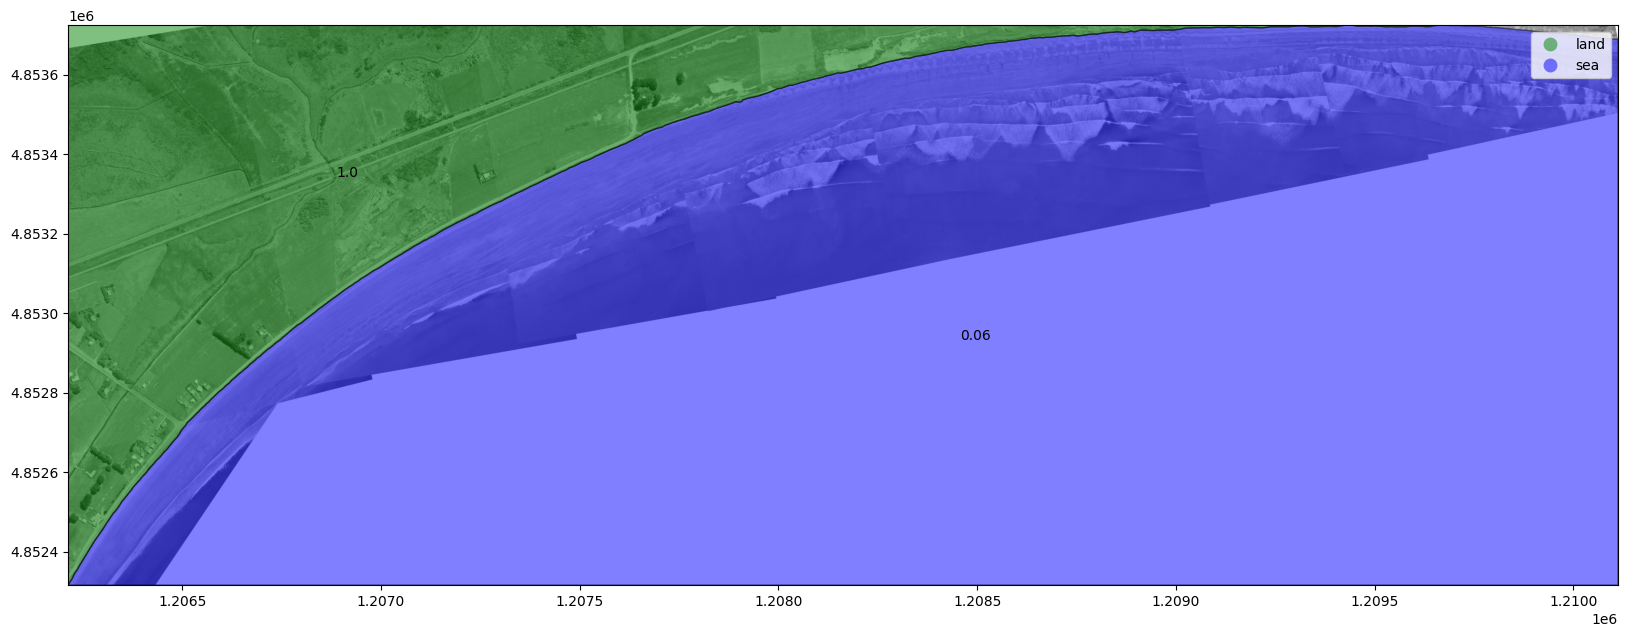

In [30]:
# Plot the results, and check it all looks ok
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)

cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
split_bboxes.plot(ax=ax, alpha=.5, column='class', cmap=cmap, categorical=True, legend=True, edgecolor='black')
split_bboxes.apply(lambda x: ax.annotate(text=round(x.fraction_inland, 2), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

#relevant_coastline.plot(ax=ax, alpha=.5, edgecolor="cyan")

b = split_bboxes.total_bounds
xlim = ([b[0], b[2]])
ylim = ([b[1], b[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)